#Load data

In [216]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
        # transforms.RandomApply([transforms.Resize(112),
        #                         transforms.RandomCrop((112, 96))]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  
        # transforms.RandomErasing()
])

# data_path = 'data/casia-webface'
# data_path = 'data/webface-10'
train_data_path = 'data/webface-small'

batch_size = 50

train_data = datasets.ImageFolder(train_data_path, transform=train_transform)

train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size)

Make sure dataset is loaded correctly

In [217]:
iterator = iter(train_loader)
image, label = next(iterator)

print("image", image[0].shape)
print("label", label[0])
print("label", label[1])
print("label", label[2])
print("label", label[3])

image torch.Size([3, 112, 112])
label tensor(73)
label tensor(24)
label tensor(67)
label tensor(27)


#Init the model

In [218]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim
import os
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = resnet18()
num_classes = len(os.listdir(data_path))
print(num_classes)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

model.fc = nn.Linear(512, num_classes)
model.to(device)


100
mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [219]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Test showing a picture and running model

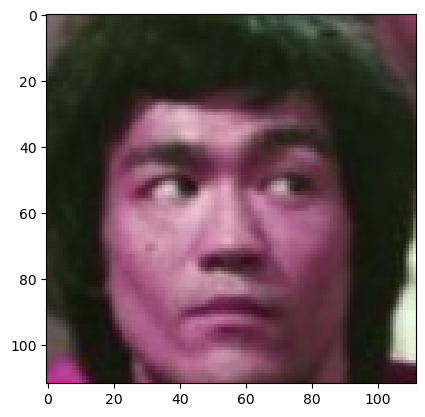

mps
tensor([[-0.6149, -0.1289, -0.1302, -0.0227, -0.8076, -0.1467,  0.1974,  1.2133,
          0.3234, -0.7112, -0.0239, -0.2430, -0.0306,  0.0805, -0.3821,  0.0453,
          0.2252,  0.6895,  0.1170,  0.7257, -0.2159, -0.3224, -0.6051,  0.3421,
         -0.0631,  0.2167, -0.3227, -0.2269,  0.6019, -0.0374, -0.1077, -0.3835,
         -0.5064, -0.0093, -0.3664, -0.0832, -0.0201,  0.2960,  0.1717,  0.7433,
         -0.1948,  0.4207,  0.1646,  0.5015,  0.3738,  0.0475,  0.3252,  0.5091,
          0.0222, -0.8174, -0.2126, -0.5695, -0.6922,  0.0603,  0.4668, -0.6079,
         -0.9358,  0.2594,  0.0947, -0.4719,  0.0569, -0.3587, -0.3473,  0.0018,
          0.3921, -0.7335,  0.4245, -0.4821,  0.1334, -0.3403, -1.0146, -0.6151,
         -0.6369,  0.3551, -0.0675,  0.4638,  0.1759, -0.2479, -0.0134, -0.2003,
          0.2979, -0.4705, -0.3268, -0.1120,  0.4499, -0.3476,  0.4995, -0.7491,
          0.0984,  0.3434, -0.2603,  0.5068, -0.2800, -0.1423,  0.5851,  0.6822,
         -0.7083, -0.350

In [220]:
from PIL import Image

img = Image.open('./data/webface-10/000000/00000001.jpg')
timg = transforms.ToTensor()(img)
imshow(timg)
print(device)
timg = timg.unsqueeze(0).to(device)
# model.to(device)
print(model(timg))

#Load lfw dataset

In [221]:
batch_size_test = 50

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  
])

lfw_test = datasets.LFWPairs(root='data', split='10fold', transform=test_transform, download=True)

test_loader = DataLoader(lfw_test, batch_size=batch_size_test, shuffle=True)

Files already downloaded and verified


In [222]:
print(len(lfw_test))
print(len(test_loader))

6000
120


Feature extractor

In [223]:
import torch.nn.functional as F

def model_to_extractor(model):
    model.eval()
    feature_map = list(model.children())
    feature_map.pop()  # remove the final "class prediction" layer
    extractor = nn.Sequential(*feature_map) # create feature extractor
    # Inspect the structure - it is a nested list of various modules
    # print extractor[-1]       
    # print extractor[-2][-1]   
    return extractor

extractor = model_to_extractor(model)

def extract_features():
    labels_list = []
    extractor.to(device)
    extractor.eval()
    feat_pair1 = []
    feat_pair2 = []
    n = 0

    with torch.no_grad():
        for (imgs1, imgs2, labels) in iter(test_loader):
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
            imgs1_out = extractor(imgs1)
            imgs2_out = extractor(imgs2)
            feat_pair1.append(imgs1_out.data)
            feat_pair2.append(imgs2_out.data)
            labels_list.append(labels.data)
            if (n == 10):
                print('done extracting for iteration', n)
        
    return feat_pair1, feat_pair2, labels_list


In [224]:
def tlist_to_squeezed(tensor_list):
    #Merge the array of tensors into one tensor
    merged_tensor = torch.cat(tensor_list, dim=0)
    return merged_tensor.squeeze() #Remove the extra dimension

def tlist_distance(tlist1, tlist2):
    tlist1 = tlist_to_squeezed(tlist1)
    tlist2 = tlist_to_squeezed(tlist2)
    return torch.norm(tlist1 - tlist2, dim=1)

Validate model function 1, plot curves

In [225]:
import matplotlib.pyplot as plt
import sklearn.metrics

def get_test_accuracy():
    feat_pair1, feat_pair2, labels = extract_features()
    feature_distance = tlist_distance(feat_pair1, feat_pair2)
    feat_dist = feature_distance.cpu().numpy()

    # Eval metrics
    scores = -feat_dist
    gt = torch.cat(labels).numpy()

    roc_auc = sklearn.metrics.roc_auc_score(gt, scores)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(gt, scores)
    fig_path = "./figures/roc_auc.png"
    print ('ROC-AUC: %.04f' % roc_auc)
    # Plot and save ROC curve
    plot_roc(fpr, tpr, roc_auc, fig_path)
    return roc_auc

def plot_roc(fpr, tpr, roc_auc, fig_path, show=False):
    plt.title('ROC - lfw dev-test')
    plt.plot(fpr, tpr, lw=2, label='ROC (auc = %0.4f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(fig_path, bbox_inches='tight')
    if show:
        plt.show()

# get_test_accuracy()

Validate model, function 2

In [226]:
import time 

def extractDeepFeature(img, model, device):
    # model.to(device)
    img = img.to(device)
    fc = model(img)
    fc = fc.to('cpu').squeeze()
    # fc = fc.to('cpu')
    
    return fc

def KFold(n=6000, n_folds=10):
    folds = []
    base = list(range(n))
    for i in range(n_folds):
        test = base[int(i * n / n_folds):int((i + 1) * n / n_folds)]
        train = list(set(base) - set(test))
        folds.append([train, test])
    return folds


def eval_acc(threshold, diff):
    y_true = []
    y_predict = []
    for d in diff:
        same = 1 if float(d[0]) > threshold else 0
        y_predict.append(same)
        y_true.append(int(d[1]))
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    accuracy = 1.0 * np.count_nonzero(y_true == y_predict) / len(y_true)
    return accuracy


def find_best_threshold(thresholds, predicts):
    best_threshold = best_acc = 0
    for threshold in thresholds:
        accuracy = eval_acc(threshold, predicts)
        if accuracy >= best_acc:
            best_acc = accuracy
            best_threshold = threshold
    return best_threshold

def cosine_similarity(f1, f2):
    # compute cosine_similarity for 2-D array
    f1 = f1.numpy()
    f2 = f2.numpy()

    A = np.sum(f1*f2, axis=1)
    B = np.linalg.norm(f1, axis=1) * np.linalg.norm(f2, axis=1) + 1e-5

    return A / B

def compute_distance(img1, img2, model, flag, device):
        f1 = extractDeepFeature(img1, model, device)
        f2 = extractDeepFeature(img2, model, device)

        distance = cosine_similarity(f1, f2)

        flag = flag.squeeze().numpy()
        return np.stack((distance, flag), axis=1)

def obtain_acc(predicts, num_class, start):
    accuracy = []
    thd = []
    folds = KFold(n=num_class, n_folds=10)
    thresholds = np.arange(-1.0, 1.0, 0.005)
    
    for idx, (train, test) in enumerate(folds):
        best_thresh = find_best_threshold(thresholds, predicts[train])
        accuracy.append(eval_acc(best_thresh, predicts[test]))
        thd.append(best_thresh)
    end = time.time()
    time_used = (end - start) / 60.0
    # logger.info('LFW_ACC={:.4f} std={:.4f} thd={:.4f} time_used={:.4f} mins'.format(np.mean(accuracy), np.std(accuracy), np.mean(thd), time_used))
    print('LFW_ACC={:.4f} std={:.4f} thd={:.4f} time_used={:.4f} mins'.format(np.mean(accuracy), np.std(accuracy), np.mean(thd), time_used))
    return np.mean(accuracy)


def eval(model, num_classes, test_loader, device):
    predicts = np.zeros(shape=(len(test_loader.dataset), 2))

    model.eval()
    start = time.time()

    cur = 0
    with torch.no_grad():
        for (img1, img2, flag) in iter(test_loader):
            predicts[cur:cur+flag.shape[0]] = compute_distance(img1, img2, model, flag, device)
            cur += flag.shape[0]
    assert cur == predicts.shape[0]

    accuracy = obtain_acc(predicts, num_classes, start)

    # visualize the masks stats
    print('LFW_ACC', np.mean(accuracy))

    return np.mean(accuracy), predicts

In [227]:
# eval(model, len(lfw_test), test_loader, device)

epoch: 0, iter: 100, loss: 4.066561698913574, time: 0.0655999580048956
epoch: 0, iter: 200, loss: 3.8772132396698, time: 0.06328099998063408
train acc: 0.14217622225248536
ROC-AUC: 0.5685
val acc 1: 0.568465
LFW_ACC=0.5502 std=0.0141 thd=0.9045 time_used=0.7210 mins
LFW_ACC 0.5501666666666667
val acc 2:  0.5501666666666667
epoch: 1, iter: 100, loss: 2.7856805324554443, time: 0.057931499992264435
epoch: 1, iter: 200, loss: 3.188426971435547, time: 0.06235787502373569
epoch: 2, iter: 100, loss: 2.270387887954712, time: 0.06343374997959472
epoch: 2, iter: 200, loss: 2.278806209564209, time: 0.06560912498389371
epoch: 3, iter: 100, loss: 1.6347308158874512, time: 0.06675829199957661
epoch: 3, iter: 200, loss: 1.6957638263702393, time: 0.06413108299602754
epoch: 4, iter: 100, loss: 1.454247236251831, time: 0.06303258400293998
epoch: 4, iter: 200, loss: 1.176957368850708, time: 0.06660537500283681
epoch: 5, iter: 100, loss: 1.5491890907287598, time: 0.060924666991923004
epoch: 5, iter: 200, 

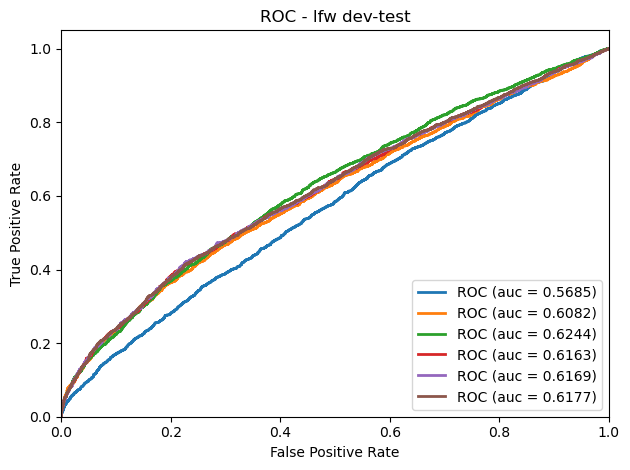

In [228]:
import time

learning_rate = 0.1
num_epochs = 50
weight_decay = 0.0
momentum = 0.9

lr_milestones = [28, 38, 46]
lr_gamma = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                    lr=learning_rate,
                    momentum=momentum,
                    weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_milestones, gamma=lr_gamma)

def get_train_accuracy(model: nn.Module):
    correct = 0
    total = 0
    n = 0
    with torch.no_grad():
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device) # Move input data to the same device as the model
            model.eval()
            output = model(imgs) # We don't need to run torch.softmax
            pred = output.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(labels).sum().item()
            total += imgs.shape[0]
            n += 1
    return correct / total 

for epoch in range(num_epochs):
    n = 0
    for imgs, labels in iter(train_loader):
        tic = time.perf_counter()
        # imshow(imgs[0])
        imgs = imgs.to(device)
        labels = labels.to(device)

        model.train() # annotate model for training

        out = model(imgs)
        loss = loss_fn(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        toc = time.perf_counter()
        n += 1
        if n % 100 == 0:
            print('epoch: {}, iter: {}, loss: {}, time: {}'.format(epoch, n, loss, toc - tic))
    if epoch % 10 == 0:
        print('train acc:', get_train_accuracy(model))
        print('val acc 1:', get_test_accuracy())
        print('val acc 2: ', eval(model, len(lfw_test), test_loader, device)[0])
    lr_scheduler.step() 

print('train acc:', get_train_accuracy(model))
print('val acc 1:', get_test_accuracy())
print('val acc 2: ', eval(model, len(lfw_test), test_loader, device)[0])